# Using the ml4qc package for a specific example analysis ("CATI3")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI3".

This project is designed to explore the potential for ML-based tools to use only non-PII interview profiles (features constructed only from interview metadata and paradata) to identify outliers and submissions that are likely to be rejected by a human reviewer. It also explores use of ML techniques to explore interviewer effects.

In this case, all successful interviews were approved with the same quality classification, so there's no training data for rejected interviews. Therefore, we instead aim to predict successful (vs. failed) interviews, which turns out to be trivial for all of the ML algorithms.

In [1]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **Surveyor_ID** - ID of enumerator who conducted the interview
* **TA** - Relative path to text audit `.csv` file
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **phone_response_short** - Phone call result summary
* **KEY** - Unique submission ID

In [8]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati3/cati3.csv"), attachments_available=True)

# initialize location for outputs
output_path_prefix = "~/ml4qc-data/collab1/cati3/"

# initialize enumerator ID column name
enumerator_id_column = "Surveyor_ID"

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize call result
print("Submission DataFrame call result:")
print(submissions_df.phone_response_short.value_counts())
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.TA)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate          798
starttime               798
endtime                 798
deviceid                798
subscriberid            798
TA                      798
Surveyor_ID             798
phone_response_short    798
review_status           798
review_quality          798
dtype: int64

Submission DataFrame call result:
Number not working, not active or out of the c...    441
Complete                                             258
Number ringed but was not answered/Number busy        77
Rescheduled                                           13
Number ringed but the call was dropped                 5
Wrong number                                           2
Refused                                                2
Name: phone_response_short, dtype: Int64

Submission DataFrame review status and quality:
N/A         540
APPROVED    258
Name: review_status, dtype: Int64
N/A     540
GOOD    258
Name: review_quality, dtype: Int64

Text audit DataFrame f

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using one of three target definitions:

1. Rejected submissions
2. Submissions classified as poor quality
3. Submissions that are not APPROVED as GOOD quality (i.e., rejected or another quality)

We use PCA to reduce our feature dimensions, targeting 99% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [26]:
%%time

from ml4qc import SurveyMLClassifier

# random state for reproducible results (or None)
random_state = 501

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.99

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["SubmissionDate", "starttime", "endtime", "TA"], axis=1).copy(deep=True)
starting_n = len(analysis_df.index)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]
ending_n = len(analysis_df.index)
print(f"Dropped {starting_n-ending_n}/{starting_n} observations with missing data, for a loss of {((starting_n-ending_n)/starting_n)*100:.2f}%")
print()

# organize DataFrames with features and classes for prediction
class_columns = ["review_status", "review_quality", "phone_response_short", enumerator_id_column]
classes_df = analysis_df.loc[:, class_columns]
features_df = analysis_df.drop(class_columns, axis=1)

# set our target for prediction
# target_description = "REJECTED"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
target_description = "Not APPROVED+GOOD"
classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()
print(f"Target base rate: {(len(target_df[target_df.target == 1])/len(target_df))*100:.2f}%")
print()

# create SurveyML object with 25% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.25, cv_when_training=True, random_state=random_state, verbose=True, n_jobs=-3, calibration_method='isotonic', threshold="optimal_f", threshold_value=1)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Dropped 0/798 observations with missing data, for a loss of 0.00%

Target description: Not APPROVED+GOOD
1    540
0    258
Name: target, dtype: int64

Target base rate: 67.67%

numeric features: 173
numeric_binary features: 58
numeric_unit_interval features: 86
numeric_other features: 29
datetime features: 0
other features: 2
  Starting training set shape: (598, 175)
Starting prediction set shape: (200, 175)
     Final training set shape: (598, 75)
   Final prediction set shape: (200, 75)
CPU times: user 459 ms, sys: 70.5 ms, total: 529 ms
Wall time: 200 ms


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [27]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser(output_path_prefix + "outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 54 (6.7669172932330826%)
CPU times: user 109 ms, sys: 5.47 ms, total: 115 ms
Wall time: 120 ms


target,0,1
is_outlier,,
0,0.852713,0.97037
1,0.147287,0.02963


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Logistic regression
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -1.3384489227694245e-07
Parameters: {'C': 96.15441410241405, 'class_weight': None, 'penalty': 'l2'}

Running prediction model...

      Training set: (598, 75) (415 positive)
    Prediction set: (200, 75)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.9020078722681377

Fitting model...

Cross-validating model on training set...

          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  100.00%
    Prediction precision:  100.00%
          Prediction F-1:  1.0
      Test ROC_AUC Score:  1.0


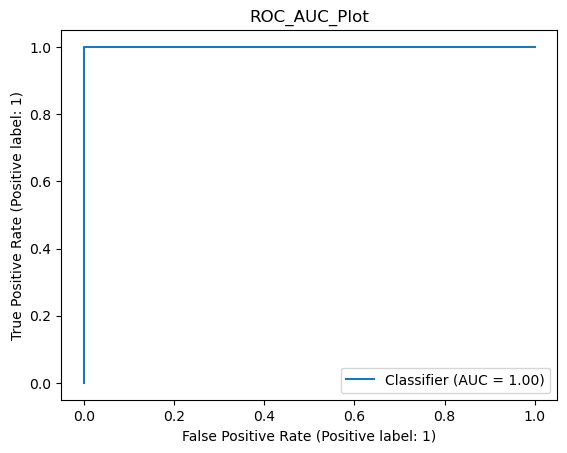

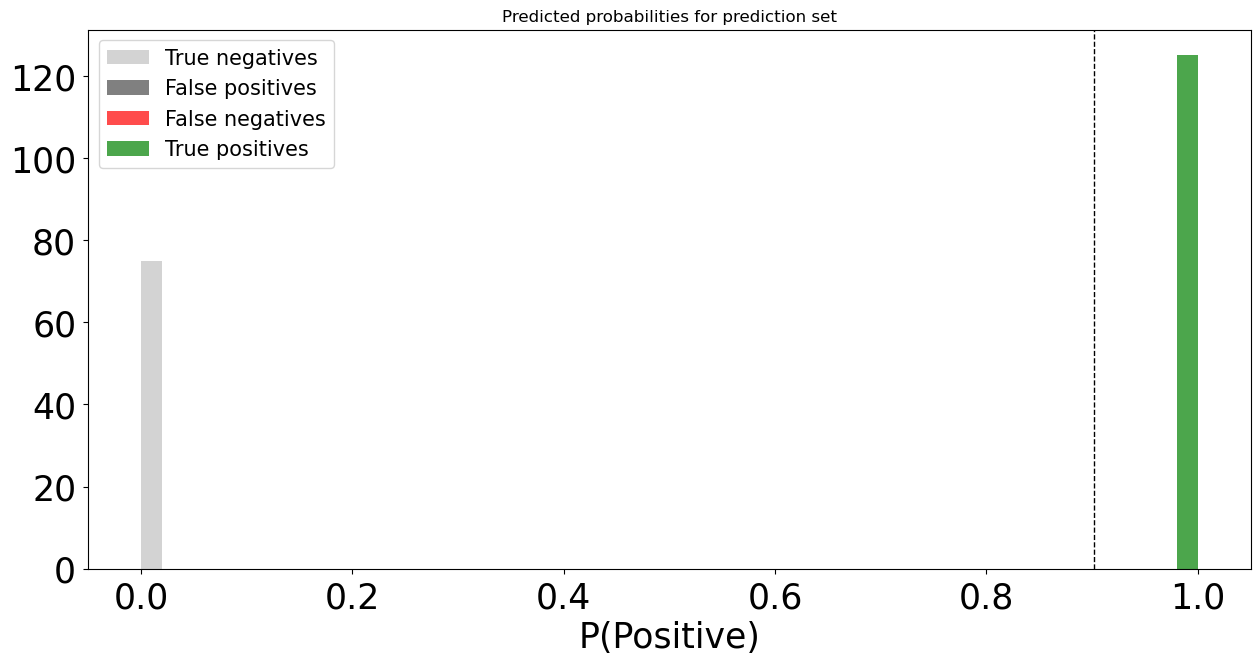

Test P(1) =  62.50%
Test P(1 | predicted 1) =  100.00%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       125

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



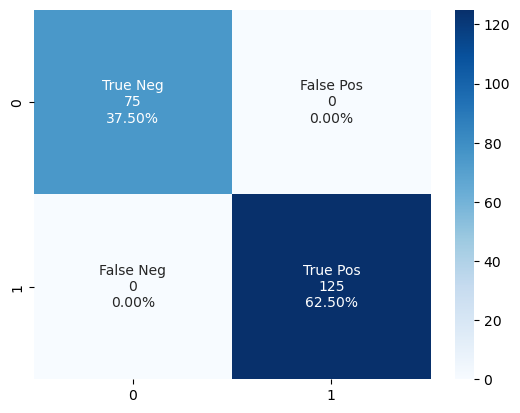

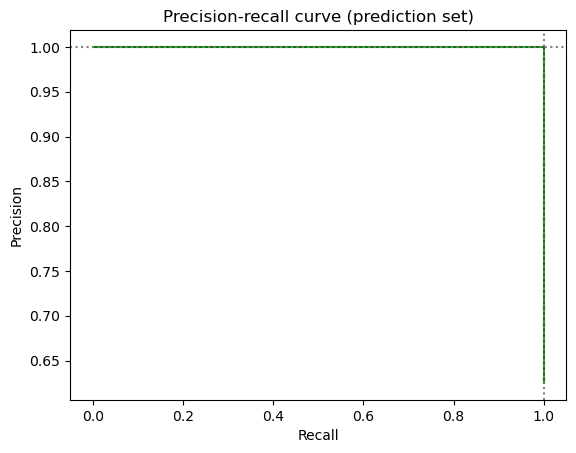

Cross validation results: 

fit_time: 0.03486560185750325 (SD: 0.0031657539857067444)
score_time: 0.0024027188618977865 (SD: 0.0006501264246000787)
test_accuracy: 0.9977777777777778 (SD: 0.0047790695928014645)
test_precision: 1.0 (SD: 0.0)
test_f1: 0.998378911061838 (SD: 0.003490596423414882)
test_roc_auc: 1.0 (SD: 0.0)
test_neg_log_loss: -0.0009455675291642327 (SD: 0.0012004816731507673)
test_neg_brier_score: -0.00011919028306762495 (SD: 0.00016863928184406)

Predictions made: 200
CPU times: user 743 ms, sys: 140 ms, total: 883 ms
Wall time: 1.26 s


In [28]:
%%time

model_description = "Logistic regression"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.linear_model import LogisticRegression

# Option 1: use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# # Option 2: use parameters from prior run
# params = {'C': 0.0008242861714196172, 'penalty': 'l2', 'class_weight': None}

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Decision tree
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: 0.0
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15, 'class_weight': None}

Running prediction model...

      Training set: (598, 75) (415 positive)
    Prediction set: (200, 75)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 1.0

Fitting model...

Cross-validating model on training set...

          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  100.00%
    Prediction precision:  100.00%
          Prediction F-1:  1.0
      Test ROC_AUC Score:  1.0


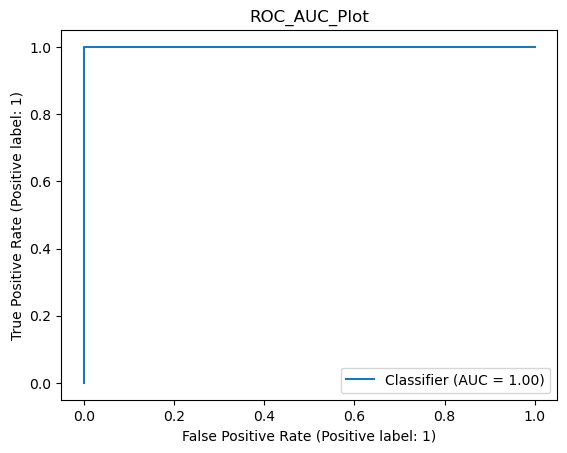

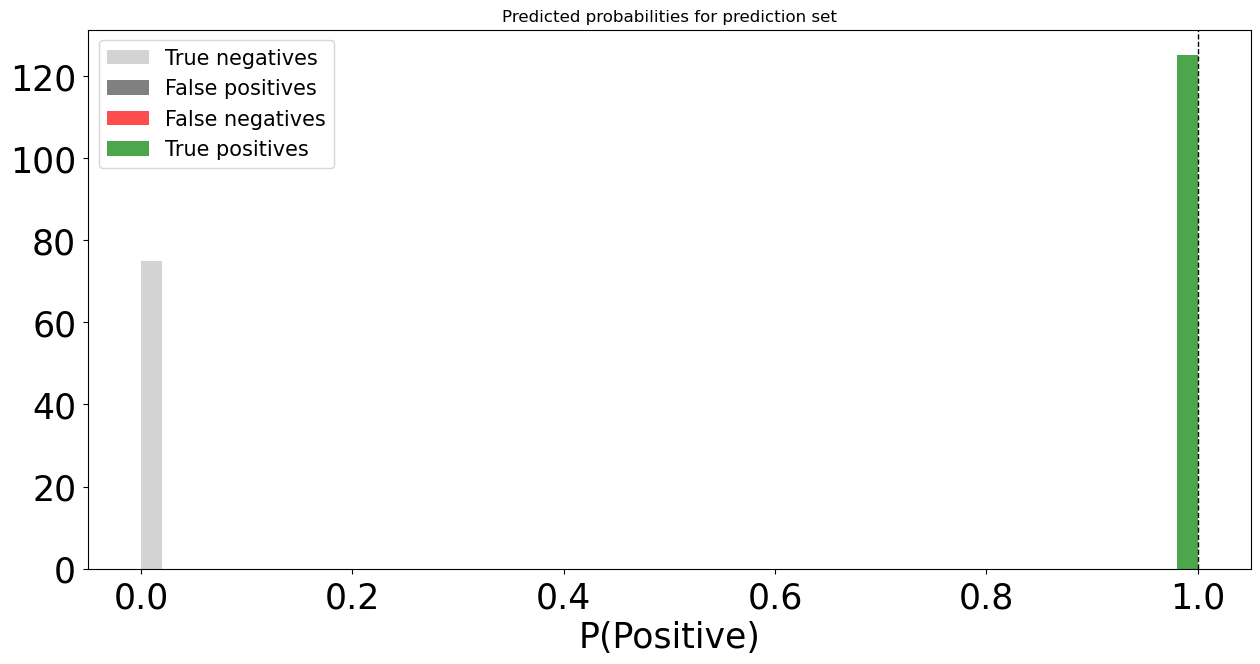

Test P(1) =  62.50%
Test P(1 | predicted 1) =  100.00%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       125

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



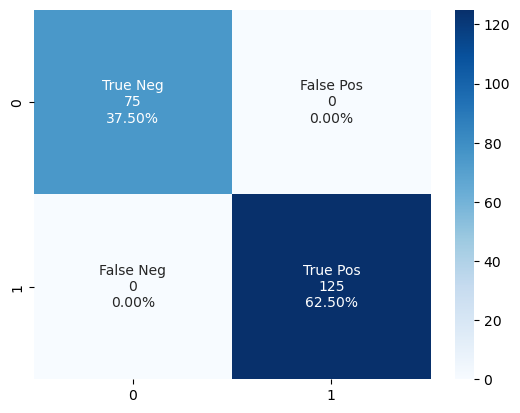

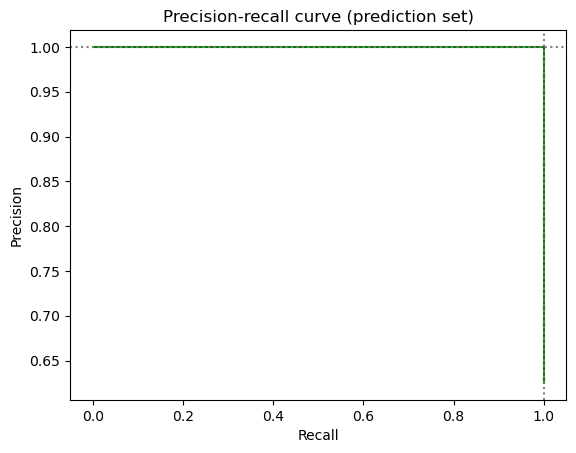

Cross validation results: 

fit_time: 0.020736519495646158 (SD: 0.00199669573483787)
score_time: 0.0021422863006591796 (SD: 0.0003467711893669852)
test_accuracy: 1.0 (SD: 0.0)
test_precision: 1.0 (SD: 0.0)
test_f1: 1.0 (SD: 0.0)
test_roc_auc: 1.0 (SD: 0.0)
test_neg_log_loss: -2.2204460492503136e-16 (SD: 0.0)
test_neg_brier_score: 0.0 (SD: 0.0)

Predictions made: 200
CPU times: user 896 ms, sys: 84.3 ms, total: 980 ms
Wall time: 1.63 s


In [29]:
%%time

model_description = "Decision tree"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Random forest
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: 0.0
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 15, 'class_weight': None, 'bootstrap': True}

Running prediction model...

      Training set: (598, 75) (415 positive)
    Prediction set: (200, 75)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 1.0

Fitting model...

Cross-validating model on training set...

          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  100.00%
    Prediction precision:  100.00%
          Prediction F-1:  1.0
      Test ROC_AUC Score:  1.0


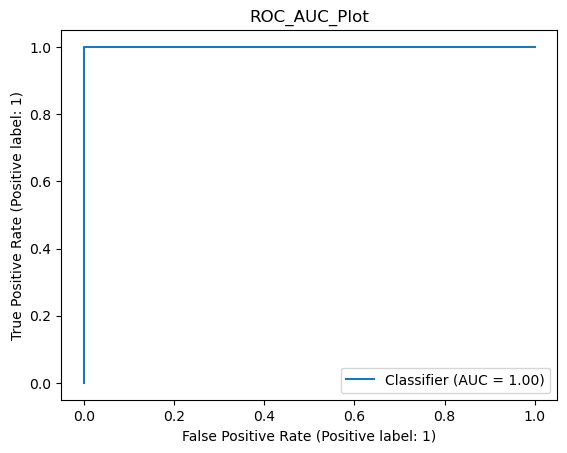

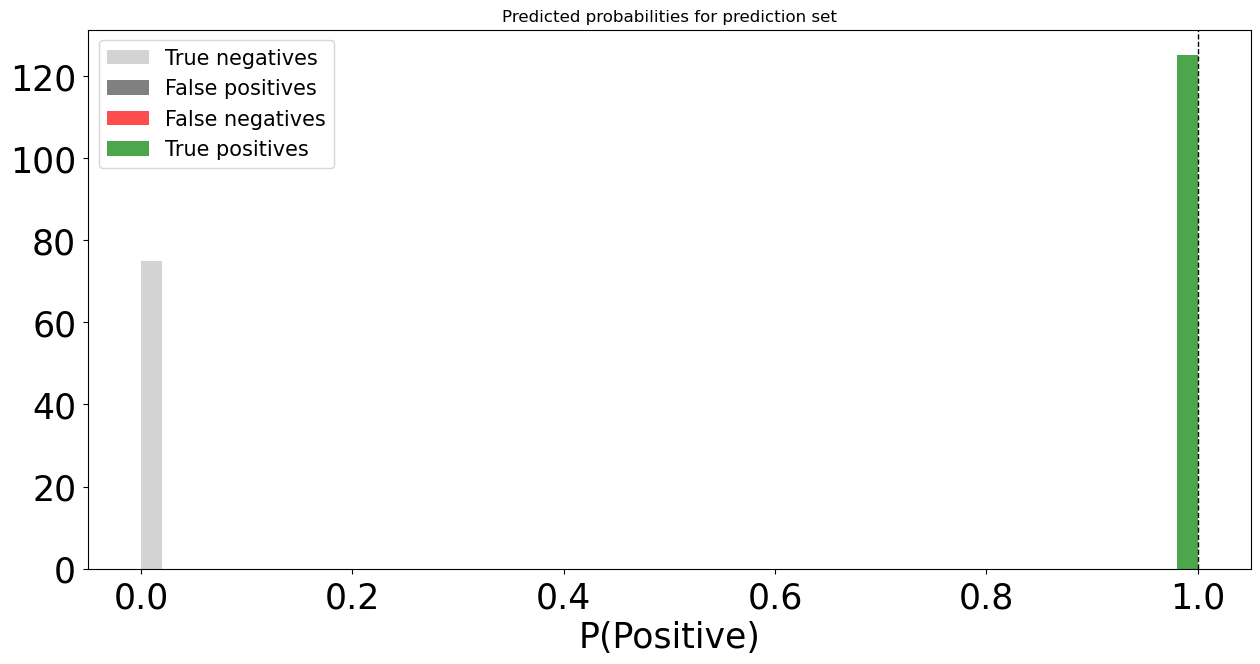

Test P(1) =  62.50%
Test P(1 | predicted 1) =  100.00%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       125

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



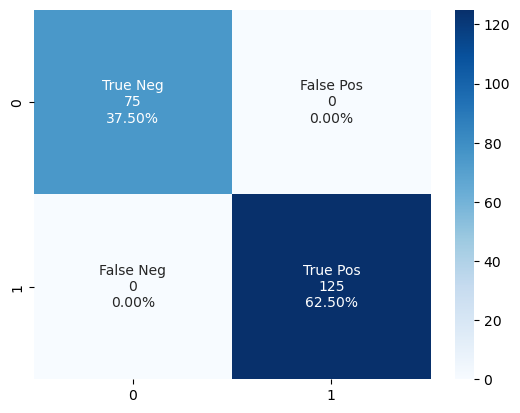

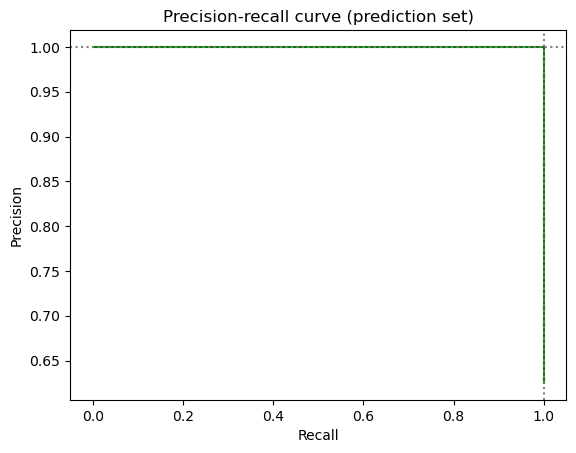

Cross validation results: 

fit_time: 5.652331336339315 (SD: 0.11857890292459547)
score_time: 0.057111660639444985 (SD: 0.025935647562884113)
test_accuracy: 1.0 (SD: 0.0)
test_precision: 1.0 (SD: 0.0)
test_f1: 1.0 (SD: 0.0)
test_roc_auc: 1.0 (SD: 0.0)
test_neg_log_loss: -2.2204460492503136e-16 (SD: 0.0)
test_neg_brier_score: 0.0 (SD: 0.0)

Predictions made: 200
CPU times: user 9.73 s, sys: 379 ms, total: 10.1 s
Wall time: 44.2 s


In [30]:
%%time

model_description = "Random forest"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: XGBoost
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 54 candidates, totalling 810 fits


/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best neg_brier_score: -1.8675644929442038e-05
Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'min_child_weight': 1, 'max_depth': 2}

Running prediction model...

      Training set: (598, 75) (415 positive)
    Prediction set: (200, 75)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 1.0

Fitting model...

Cross-validating model on training set...

          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  100.00%
    Prediction precision:  100.00%
          Prediction F-1:  1.0
      Test ROC_AUC Score:  1.0


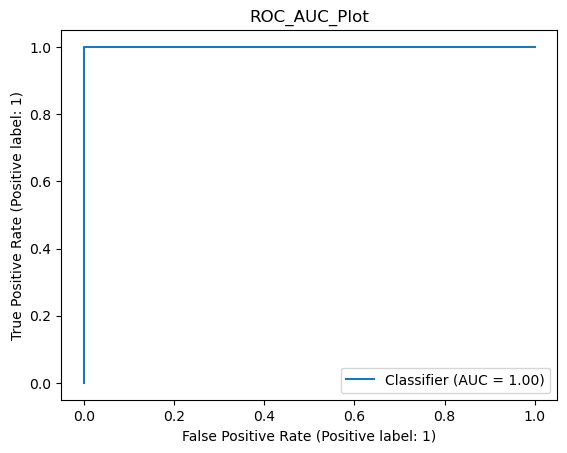

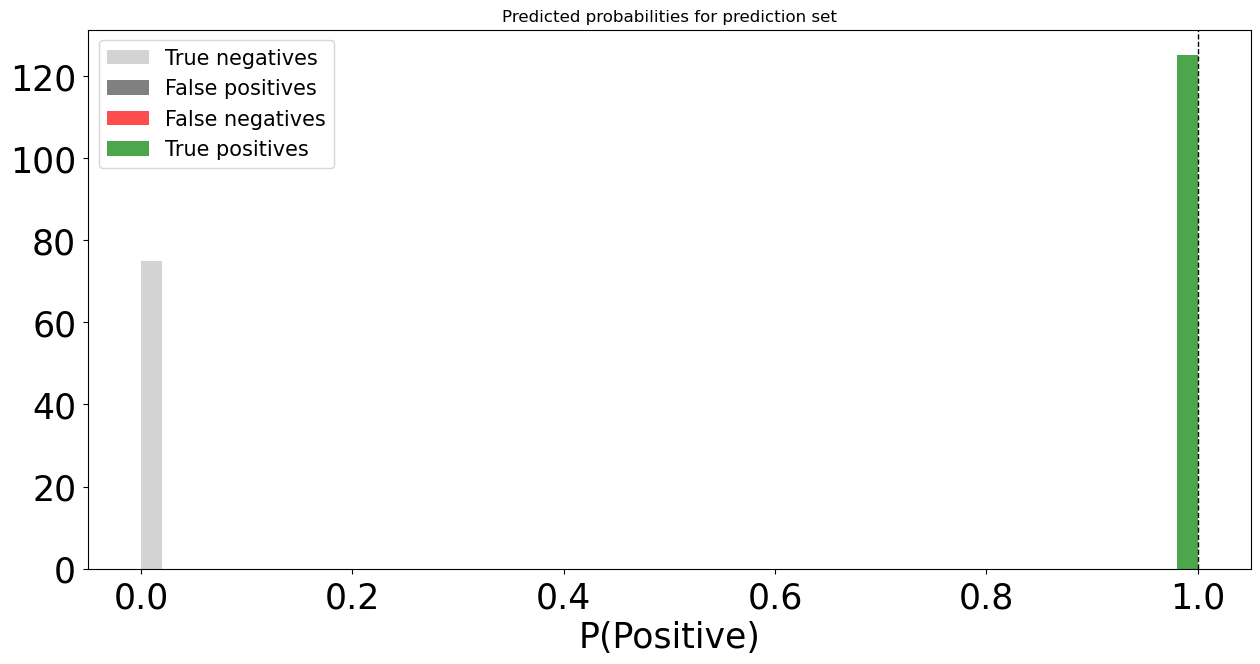

Test P(1) =  62.50%
Test P(1 | predicted 1) =  100.00%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       125

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



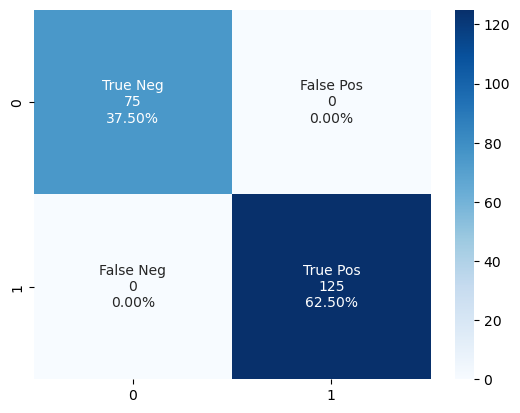

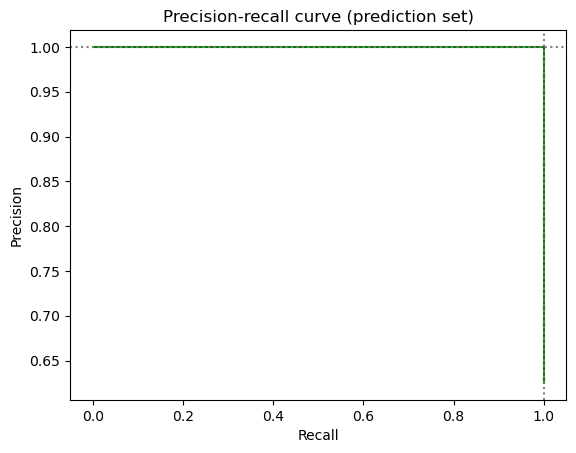

Cross validation results: 

fit_time: 0.6663694540659587 (SD: 0.056265363737895084)
score_time: 0.004059330622355143 (SD: 0.002342441333818208)
test_accuracy: 0.9955555555555555 (SD: 0.006712803318663668)
test_precision: 1.0 (SD: 0.0)
test_f1: 0.9967528948016753 (SD: 0.004908968033604396)
test_roc_auc: 1.0 (SD: 0.0)
test_neg_log_loss: -1.150121079832987e-06 (SD: 1.737120735017405e-06)
test_neg_brier_score: -2.975481550038239e-10 (SD: 4.4941100453368105e-10)

Predictions made: 200
CPU times: user 2.7 s, sys: 1.14 s, total: 3.84 s
Wall time: 7.35 s


In [31]:
%%time

model_description = "XGBoost"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: Not APPROVED+GOOD
       Model: Neural network
     Scoring: neg_brier_score

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 75)                5700      
                                                                 
 dense_51 (Dense)            (None, 1)                 76        
                                                                 
Total params: 5,776
Trainable params: 5,776
Non-trainable params: 0
_________________________________________________________________
None

Running prediction model...

      Training set: (598, 75) (415 positive)
    Prediction set: (200, 75)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.9526114523410797

Fitting model...

Cross-validating model on training set...



          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  100.00%
    Prediction precision:  100.00%
          Prediction F-1:  1.0
      Test ROC_AUC Score:  1.0


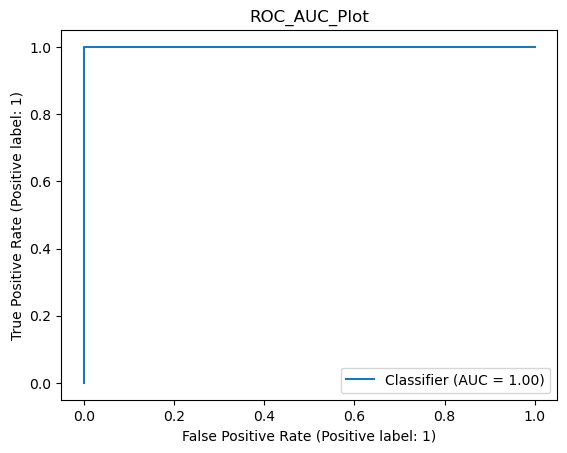

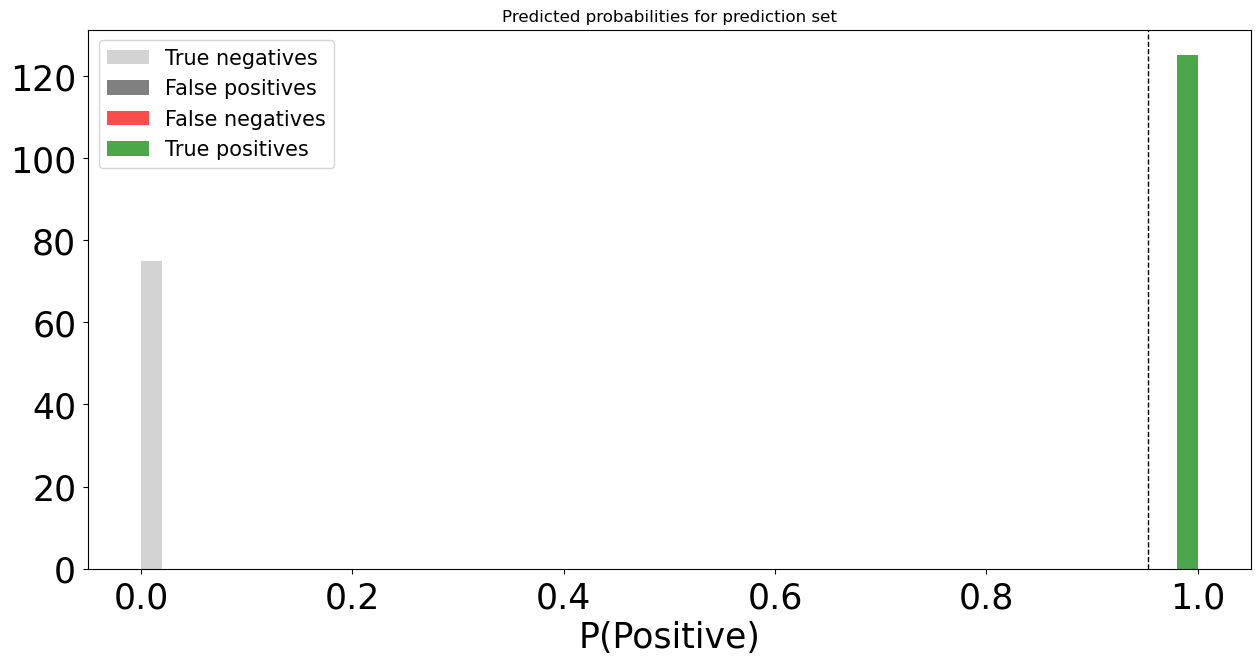

Test P(1) =  62.50%
Test P(1 | predicted 1) =  100.00%
Test P(1 | predicted 0) =  0.00%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00       125

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



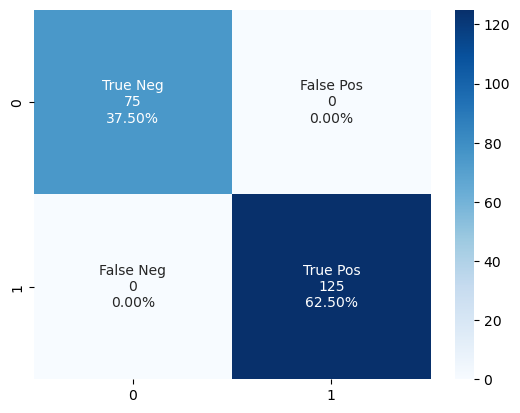

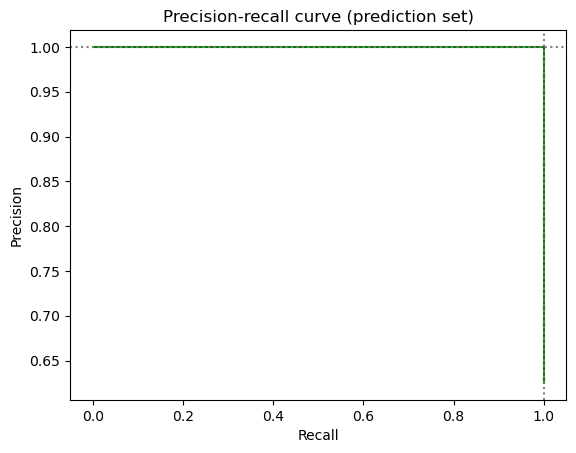

Cross validation results: 

fit_time: 7.954554510116577 (SD: 1.710019034212606)
score_time: 0.08940480550130209 (SD: 0.007786623841934243)
test_accuracy: 0.9994444444444445 (SD: 0.0020786985482077382)
test_precision: 1.0 (SD: 0.0)
test_f1: 0.9995959595959596 (SD: 0.0015117807623328872)
test_roc_auc: 1.0 (SD: 0.0)
test_neg_log_loss: -0.00012710704697783476 (SD: 0.0001916957268475832)
test_neg_brier_score: -3.588438091311971e-06 (SD: 6.840563462665268e-06)

Predictions made: 200
CPU times: user 8.1 s, sys: 840 ms, total: 8.94 s
Wall time: 33.3 s


In [32]:
%%time

model_description = "Neural network"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from scikeras.wrappers import KerasClassifier
import numpy as np

# Option 1: use cross validation to find the optimal hyperparameters
# import sklearn as skl
# classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
#   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
# search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
# params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# Option 2: use results from an earlier CV search
# Best neg_brier_score: -7.717961815697515e-06
# Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 80, 'model__activation': 'relu', 'model__dropout_rate': 0.25, 'model__features': 75, 'model__hidden_layers': 1, 'model__include_dropout': False, 'model__initial_units': 75, 'model__l2_factor': 0.0073367286842611285, 'model__l2_regularization': True, 'model__output_bias': array([-0.81879237])}
params = {'batch_size': 32, 'class_weight': None, 'epochs': 80, 'model__activation': 'relu', 'model__dropout_rate': 0.25, 'model__features': surveyml.num_features, 'model__hidden_layers': 1, 'model__include_dropout': False, 'model__initial_units': surveyml.num_features, 'model__l2_factor': 0.0073367286842611285, 'model__l2_regularization': True, 'model__output_bias': [np.log([surveyml.pos_train/surveyml.neg_train])]}

# output summary of model
print(surveyml.build_nn_model(**{param[len("model__"):]:params[param] for param in params if param.startswith("model__")}).summary())
print()

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print()
print(f"Predictions made: {len(predictions)}")

### Enumerator analysis

The following analyses seek to take the interview profiles used for the analysis above, and consider empirical enumerator effects and relationships.

In [33]:
# summarize interview counts by enumerator ID
print(classes_df[enumerator_id_column].value_counts())

FR1855    260
FR2254    198
FR2238    197
FR1333    143
Name: Surveyor_ID, dtype: Int64


#### Cluster analysis

This first approach seeks to identify natural clusters of interview profiles, and tests to see whether clusters and enumerators are statistically independent. The clusters are saved to disk, and the p value is reported for a single chi-squared test of independence.

In this case, the primary clusters identified are completed vs. failed interviews, and there appear to be strong enumerator effects (p < 0.00000000001).

In [37]:
# identify clusters
clusters_df = surveyml.identify_clusters(min_clusters=2, max_clusters=10, separate_outliers=True)

# add enumerator ID's and save to disk
clusters_df[enumerator_id_column] = classes_df[enumerator_id_column]
clusters_df["phone_response_short"] = classes_df["phone_response_short"]
clusters_df.to_csv(os.path.expanduser(output_path_prefix + "interview_clusters.csv"))

print()
print(f"Final clusters saved to disk:")
print(clusters_df.cluster.value_counts())
print()

# test for independence of cluster and enumerator
from scipy.stats import chi2_contingency
cluster_by_enum = pd.crosstab(clusters_df["cluster"], clusters_df[enumerator_id_column])
test_stat, pvalue, dof, expected_freq = chi2_contingency(cluster_by_enum)

print(f"p value for chi-squared against null that enumerator and cluster are unrelated: {pvalue}")
print()

# test for independence of cluster and call outcome
cluster_by_outcome2 = pd.crosstab(clusters_df["cluster"], clusters_df["phone_response_short"])
test_stat, pvalue, dof, expected_freq = chi2_contingency(cluster_by_outcome2)
print(cluster_by_outcome2)
print()

print(f"p value for chi-squared against null that enumerator and call outcome are unrelated: {pvalue}")

Identifying outliers...
Outliers: 54 (6.7669172932330826%)
54 outliers detected, will be put in separate cluster (-1).

  Starting features shape: (744, 175)
     Final features shape: (744, 190)

Choosing best silhouette coefficient for n_clusters between 2 and 10...

Silhouette coefficient for 2 clusters: 0.5369366425146365
0    524
1    220
Name: 0, dtype: int64

Silhouette coefficient for 3 clusters: 0.2134092110251651
0    404
1    220
2    120
Name: 0, dtype: int64

Silhouette coefficient for 4 clusters: 0.22817241866610347
1    403
0    219
3    121
2      1
Name: 0, dtype: int64

Silhouette coefficient for 5 clusters: 0.21701725178337403
0    404
1    211
2    120
4      8
3      1
Name: 0, dtype: int64

Silhouette coefficient for 6 clusters: 0.22257422701897145
0    404
1    206
2    120
4      8
5      5
3      1
Name: 0, dtype: int64

Silhouette coefficient for 7 clusters: 0.22450602476477888
0    404
1    205
2    120
4      8
5      5
3      1
6      1
Name: 0, dtype: int6

#### Benchmarking against star enumerators

This next approach takes a list of known "star" enumerators (enumerators known to follow interview protocols and, in general, conduct excellent interviews) and benchmarks all interviews against those enumerators' interviews. A logistic regression classification approach is used to calculate the probability that each interview was conducted by a star enumerator. Each enumerator's average probability is then treated as a score and output to disk. Obviously, star enumerators will be scored most highly by construction.

Here, because interviewer effects seem to be strong (particularly for the single enumerator being benchmarked against), a powerful L2 regularization constant is used to generalize the model and provide for more variations in score.

In [35]:
# list star enumerators to benchmark against
star_enumerators = ["FR1333"]

# benchmark against our star enumerators
benchmark_df = surveyml.benchmark_by_category(category_df=pd.DataFrame(classes_df[enumerator_id_column]), benchmark_categories=star_enumerators, method="logistic", reg_strength=0.001, variance_to_retain=1.0)

# save results to .csv
print(f"Benchmarking against the following enumerators saved to disk: {star_enumerators}")
benchmark_df.to_csv(os.path.expanduser(output_path_prefix + "enumerator_benchmarks.csv"))

0    655
1    143
Name: is_benchmark, dtype: int64

Target base rate: 17.92%

  Starting features shape: (798, 175)
     Final features shape: (798, 190)

Fitting model...

Benchmarking against the following enumerators saved to disk: ['FR1333']


#### Investigate enumerator similarities

This next approach uses a K-nearest-neighbor approach to predict which enumerator conducted each interview, based on which interview profiles are nearest, by weighted distance, to which others. The predictions are then summarized and output to disk, in crosstabs with count and row-wise-percentages, and in a high-level summary with the following columns:

* Enumerator ID [however it's named in source data]: the enumerator ID
* `self_similarity_score`: percentage of time an enumerator's interviews were correctly predicted to be conducted by them
* `most_like_self`: 1 for cases where the enumerator's interviews were most often classified as being conducted by them, otherwise 0
* `most_like`: most frequent enumerator predicted for the enumerator's interviews
* `most_like_score`: percentage of interviews predicted to be conducted by the "most_like" enumerator
* `second_most_like`: second-most-frequent enumerator predicted for the enumerator's interviews
* `second_most_like_score`: percentage of interviews predicted to be conducted by the "second_most_like" enumerator

If you randomly assign interviews to enumerators, you generally won't want to see strong enumerator effects. Ideally, you'd see low `self_similarity_score`s and "most_like" scores that suggest that it's hard to tell which enumerator conducted which interview. In fact, you'd ideally find interview profiles to be essentially random with respect to enumerator.

Here, all enumerators are "most like" themselves, meaning that there are very strong enumerator effects, with each enumerator interviewing in a distinct manner relative to others. The p value for the chi-squared test of enumerator-predicted-enumerator independence is reported, with a p of essentially 0.

In [36]:
# predict the enumerator for each interview
enum_df = surveyml.classify_by_category(category_df=pd.DataFrame(classes_df[enumerator_id_column]), method="knn")

# test for independence of enumerator and predicted enumerator
from scipy.stats import chi2_contingency
enum_by_predicted = pd.crosstab(enum_df[enumerator_id_column], enum_df["predicted_category"])
enum_by_predicted_pct = pd.crosstab(enum_df[enumerator_id_column], enum_df["predicted_category"], normalize='index')
test_stat, pvalue, dof, expected_freq = chi2_contingency(enum_by_predicted)

print(f"p value for chi-squared against null that enumerator and predicted enumerator are unrelated: {pvalue}")
print()

# ensure all enumerators included in second dimension of crosstab, even if all 0's
for column in enum_by_predicted.index.values:
    if not column in enum_by_predicted.columns.values:
        enum_by_predicted[column] = 0
        enum_by_predicted_pct[column] = 0.0
enum_by_predicted = enum_by_predicted.reindex(sorted(enum_by_predicted.columns), axis=1)
enum_by_predicted_pct = enum_by_predicted_pct.reindex(sorted(enum_by_predicted_pct.columns), axis=1)

# create DataFrame with summary of empirical enumerator relationships
enum_relationship_df = pd.DataFrame(index=enum_by_predicted.index)
enum_relationship_df['most_like'] = enum_by_predicted_pct.columns[enum_by_predicted_pct.values.argsort(1)[:, -1]]
enum_relationship_df['second_most_like'] = enum_by_predicted_pct.columns[enum_by_predicted_pct.values.argsort(1)[:, -2]]
for index in enum_by_predicted_pct.index.values:
    enum_relationship_df.loc[index, "most_like_self"] = 1 if enum_relationship_df.loc[index, "most_like"] == index else 0
    enum_relationship_df.loc[index, "self_similarity_score"] = enum_by_predicted_pct.loc[index, index]
    enum_relationship_df.loc[index, "most_like_score"] = enum_by_predicted_pct.loc[index, enum_relationship_df.loc[index, "most_like"]]
    enum_relationship_df.loc[index, "second_most_like_score"] = enum_by_predicted_pct.loc[index, enum_relationship_df.loc[index, "second_most_like"]]
enum_relationship_df = enum_relationship_df[['self_similarity_score', 'most_like_self', 'most_like', 'most_like_score', 'second_most_like', 'second_most_like_score']]

# save results to .csv
print(f"Enumerator-predicted_enumerator crosstabs and enumerator relationships summary saved to disk")
enum_by_predicted.to_csv(os.path.expanduser(output_path_prefix + "enumerator_prediction_crosstab.csv"))
enum_by_predicted_pct.to_csv(os.path.expanduser(output_path_prefix + "enumerator_prediction_crosstab_pct.csv"))
enum_relationship_df.to_csv(os.path.expanduser(output_path_prefix + "enumerator_relationship_summary.csv"))

  Starting features shape: (798, 175)
     Final features shape: (798, 190)

Fitting model...

p value for chi-squared against null that enumerator and predicted enumerator are unrelated: 0.0

Enumerator-predicted_enumerator crosstabs and enumerator relationships summary saved to disk
